# Telecom Customer Churn – Classification Modeling & Evaluation

**Course:** COMP 9130 Applied Machine Learning  
**Project:** Mini Project 2 – Classification Challenge  
**Dataset:** Telco Customer Churn  
**Target Variable:** Churn (Yes / No)


## 1. Objective and Modeling Overview

The objective of this notebook is to build, evaluate, and compare multiple
classification models to predict **customer churn** in a telecommunications
company. Customer churn prediction is a critical business problem, as retaining
existing customers is generally less costly than acquiring new ones.

The target variable **Churn** is binary:
- `0` – Customer does not churn
- `1` – Customer churns

The dataset is **imbalanced**, with approximately 27% churned customers and 73%
non-churned customers. As a result, accuracy alone is not an appropriate
evaluation metric. Instead, this analysis focuses on **Precision**, **Recall**,
**F1-score**, and **ROC-AUC**, which provide more meaningful insight into model
performance on imbalanced data.


## 2. Evaluation Metrics and Business Considerations

In the context of customer churn prediction:

- **False Negatives (missed churners)** are costly, as the company loses customers
  without the opportunity for intervention.
- **False Positives** lead to unnecessary retention actions (e.g., discounts or
  outreach), which incur some cost but are generally less severe.

Therefore, models with **higher recall for the churn class** are preferred, even
if precision is slightly reduced. The **F1-score** is used to balance precision
and recall, while **ROC-AUC** evaluates the overall ability of the model to
distinguish between churned and non-churned customers.


## 3. Modeling Strategy

The following models are trained and compared:
1. **Logistic Regression** – baseline linear classifier
2. **Random Forest** – ensemble tree-based model
3. **LightGBM** – gradient boosting model optimized for tabular data

To address class imbalance, multiple strategies are evaluated:
- Class weighting
- SMOTE oversampling
- Threshold adjustment

Hyperparameter tuning is performed using **GridSearchCV**, and the final model is
selected based on performance metrics and business relevance.


**Why accuracy is not used:**
The churn dataset is imbalanced (~27% churn). Accuracy would be misleading because a model predicting “No churn” for all customers would still achieve high accuracy while failing to identify churners. Therefore, we prioritize Recall, Precision, F1-score, and ROC-AUC.

**Reasoning**:
The first step in the subtask is to load the dataset and perform initial exploratory data analysis. This involves loading the CSV into a DataFrame, inspecting its head, getting information about data types and non-null values, generating descriptive statistics, checking for missing values, analyzing categorical variables, and assessing the class imbalance of the target variable 'Churn'.



In [65]:
import pandas as pd

# 1. Load the dataset
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Dataset loaded successfully. Showing first 5 rows:")
# 2. Display the first 5 rows
print(df.head())

print("\nConcise summary of the DataFrame:\n")
# 3. Get a concise summary of the DataFrame
df.info()

print("\nDescriptive statistics for numerical columns:\n")
# 4. Generate descriptive statistics for numerical columns
print(df.describe())

print("\nMissing values count in each column:\n")
# 5. Check for the count of missing values
print(df.isnull().sum())

print("\nUnique values and their counts for categorical columns:\n")
# 6. Identify and display unique values and their counts for all categorical columns
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Unique values count: {df[col].nunique()}")
    print(df[col].value_counts())

print("\nClass imbalance of the target variable 'Churn':\n")
# 7. Assess the class imbalance of the target variable 'Churn'
print(df['Churn'].value_counts())
print(f"Churn percentage: {df['Churn'].value_counts(normalize=True).iloc[1]*100:.2f}%")
print(f"No Churn percentage: {df['Churn'].value_counts(normalize=True).iloc[0]*100:.2f}%")

Dataset loaded successfully. Showing first 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSuppo

/var/folders/vw/9lg5g4_946s12cftkxcr1wmr0000gn/T/ipykernel_12043/1905835917.py:24: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include='object').columns


## Data Preprocessing




In [66]:
print("Original shape of the DataFrame:", df.shape)

# 1. Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Handle missing values in 'TotalCharges' by dropping rows
df.dropna(subset=['TotalCharges'], inplace=True)

print("Shape of the DataFrame after handling missing TotalCharges:", df.shape)

# 3. Drop the 'customerID' column
df.drop('customerID', axis=1, inplace=True)

print("Shape of the DataFrame after dropping customerID:", df.shape)

# Display info after changes
print("\nConcise summary of the DataFrame after initial preprocessing:")
df.info()


Original shape of the DataFrame: (7043, 21)
Shape of the DataFrame after handling missing TotalCharges: (7032, 21)
Shape of the DataFrame after dropping customerID: (7032, 20)

Concise summary of the DataFrame after initial preprocessing:
<class 'pandas.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   str    
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   str    
 3   Dependents        7032 non-null   str    
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   str    
 6   MultipleLines     7032 non-null   str    
 7   InternetService   7032 non-null   str    
 8   OnlineSecurity    7032 non-null   str    
 9   OnlineBackup      7032 non-null   str    
 10  DeviceProtection  7032 non-null   str    
 11  TechSupport       7032 non-null   str    
 12  Streami

In [67]:
from sklearn.model_selection import train_test_split

# 4. Convert the target variable 'Churn' from 'Yes'/'No' to a binary numerical format (1/0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print("\nChurn variable converted to binary:\n")
print(df['Churn'].value_counts())

# 5. Identify all remaining categorical columns (string/object types)
categorical_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
print(f"\nCategorical columns before one-hot encoding: {categorical_cols}")

# 6. Apply one-hot encoding to these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nDataFrame after one-hot encoding:\n")
print(df_encoded.head())
print(f"\nShape of DataFrame after one-hot encoding: {df_encoded.shape}")

# 7. Separate the features (X) and the target variable (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"\nShape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

# 8. Split the dataset into training and testing sets (80/20 ratio) using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nClass distribution in original target variable:\n", y.value_counts(normalize=True))
print("\nClass distribution in y_train:\n", y_train.value_counts(normalize=True))
print("\nClass distribution in y_test:\n", y_test.value_counts(normalize=True))


Churn variable converted to binary:

Churn
0    5163
1    1869
Name: count, dtype: int64

Categorical columns before one-hot encoding: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

DataFrame after one-hot encoding:

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False 

In [68]:
from sklearn.preprocessing import StandardScaler

# 9. Identify numerical columns for scaling
numerical_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# 10. Initialize the StandardScaler
scaler = StandardScaler()

# 11. Fit the scaler on the training data and transform both training and testing sets
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nFeatures scaled successfully.\n")
print("X_train after scaling (first 5 rows):\n")
print(X_train.head())
print("\nX_test after scaling (first 5 rows):\n")
print(X_test.head())



Features scaled successfully.

X_train after scaling (first 5 rows):

      SeniorCitizen    tenure  MonthlyCharges  TotalCharges  gender_Male  \
1413      -0.439319  1.321816        0.981556      1.659900         True   
7003      -0.439319 -0.267410       -0.971546     -0.562252         True   
3355      -0.439319  1.444064        0.837066      1.756104        False   
4494      -0.439319 -1.204646        0.641092     -0.908326         True   
3541      -0.439319  0.669826       -0.808787     -0.101561        False   

      Partner_Yes  Dependents_Yes  PhoneService_Yes  \
1413         True            True              True   
7003        False           False             False   
3355         True           False              True   
4494        False           False              True   
3541         True           False             False   

      MultipleLines_No phone service  MultipleLines_Yes  ...  \
1413                           False               True  ...   
7003         

## Train Baseline Model (Logistic Regression)



In [69]:
from sklearn.linear_model import LogisticRegression

# 1. Instantiate a Logistic Regression model with class_weight='balanced' and random_state=42
lr_model = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')

print("Logistic Regression model instantiated.")

# 2. Fit the Logistic Regression model to the training data
lr_model.fit(X_train, y_train)

print("Logistic Regression model fitted to training data.")

# 3. Make predictions on the test data
y_pred_lr = lr_model.predict(X_test)

print("Predictions made on test data.")

# 4. Make probability predictions on the test data for the positive class (churn)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("Probability predictions made on test data.")

Logistic Regression model instantiated.
Logistic Regression model fitted to training data.
Predictions made on test data.
Probability predictions made on test data.


## Evaluate Baseline Model



In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\n--- Logistic Regression Model Evaluation ---\n")

# 1. Calculate Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")

# 2. Calculate Precision
precision_lr = precision_score(y_test, y_pred_lr)
print(f"Precision: {precision_lr:.4f}")

# 3. Calculate Recall
recall_lr = recall_score(y_test, y_pred_lr)
print(f"Recall: {recall_lr:.4f}")

# 4. Calculate F1-score
f1_lr = f1_score(y_test, y_pred_lr)
print(f"F1-Score: {f1_lr:.4f}")

# 5. Calculate AUC-ROC score
auc_roc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"AUC-ROC: {auc_roc_lr:.4f}")

# 6. Generate Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(conf_matrix_lr)


--- Logistic Regression Model Evaluation ---

Accuracy: 0.7249
Precision: 0.4893
Recall: 0.7941
F1-Score: 0.6055
AUC-ROC: 0.8354

Confusion Matrix:
[[723 310]
 [ 77 297]]


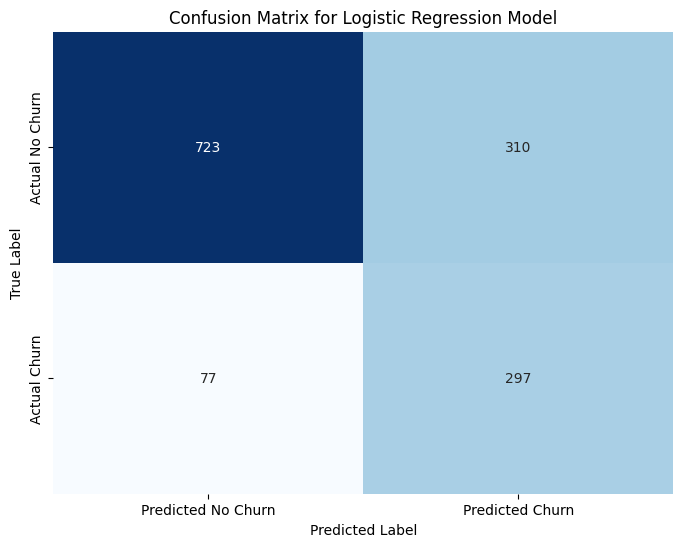

Confusion Matrix visualization displayed.


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# 7. Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix visualization displayed.")

**Business Interpretation of Errors**
- False Negatives (missed churners) are costly because the company loses customers without intervention.
- False Positives result in unnecessary retention offers but are generally less costly.
Therefore, models with higher recall for the churn class are preferred, even at the expense of slightly lower precision.

## Train Tree-Based Model



In [72]:
from sklearn.ensemble import RandomForestClassifier

# 1. Instantiate a RandomForestClassifier object with random_state=42 and class_weight='balanced'
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

print("Random Forest Classifier model instantiated.")

# 2. Fit the Random Forest model to the training data
rf_model.fit(X_train, y_train)

print("Random Forest Classifier model fitted to training data.")

# 3. Make class predictions on the test data
y_pred_rf = rf_model.predict(X_test)

print("Class predictions made on test data.")

# 4. Make probability predictions for the positive class (churn) on the test data
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Probability predictions made on test data.")

Random Forest Classifier model instantiated.
Random Forest Classifier model fitted to training data.
Class predictions made on test data.
Probability predictions made on test data.


## Evaluate Tree-Based Model



In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\n--- Random Forest Model Evaluation ---\n")

# 1. Calculate Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

# 2. Calculate Precision
precision_rf = precision_score(y_test, y_pred_rf)
print(f"Precision: {precision_rf:.4f}")

# 3. Calculate Recall
recall_rf = recall_score(y_test, y_pred_rf)
print(f"Recall: {recall_rf:.4f}")

# 4. Calculate F1-score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"F1-Score: {f1_rf:.4f}")

# 5. Calculate AUC-ROC score
auc_roc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"AUC-ROC: {auc_roc_rf:.4f}")

# 6. Generate Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(conf_matrix_rf)


--- Random Forest Model Evaluation ---

Accuracy: 0.7910
Precision: 0.6361
Recall: 0.5000
F1-Score: 0.5599
AUC-ROC: 0.8154

Confusion Matrix:
[[926 107]
 [187 187]]


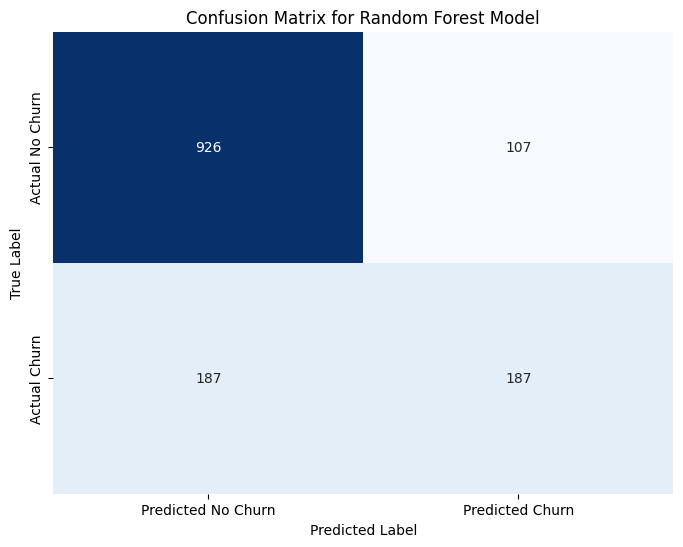

Confusion Matrix visualization displayed.


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# 7. Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix visualization displayed.")

## Train Another Classifier (LightGBM)

In [75]:
import lightgbm as lgb

# 1. Instantiate a LightGBM Classifier model with random_state=42 and enable class weight handling
lgbm_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

print("LightGBM Classifier model instantiated.")

# 2. Fit the LightGBM model to the training data
lgbm_model.fit(X_train, y_train)

print("LightGBM Classifier model fitted to training data.")

# 3. Make class predictions on the test data
y_pred_lgbm = lgbm_model.predict(X_test)

print("Class predictions made on test data.")

# 4. Make probability predictions for the positive class (churn) on the test data
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

print("Probability predictions made on test data.")

LightGBM Classifier model instantiated.
LightGBM Classifier model fitted to training data.
Class predictions made on test data.
Probability predictions made on test data.


## Evaluate Another Classifier (LightGBM)



In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\n--- LightGBM Model Evaluation ---\n")

# 1. Calculate Accuracy
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"Accuracy: {accuracy_lgbm:.4f}")

# 2. Calculate Precision
precision_lgbm = precision_score(y_test, y_pred_lgbm)
print(f"Precision: {precision_lgbm:.4f}")

# 3. Calculate Recall
recall_lgbm = recall_score(y_test, y_pred_lgbm)
print(f"Recall: {recall_lgbm:.4f}")

# 4. Calculate F1-score
f1_lgbm = f1_score(y_test, y_pred_lgbm)
print(f"F1-Score: {f1_lgbm:.4f}")

# 5. Calculate AUC-ROC score
auc_roc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
print(f"AUC-ROC: {auc_roc_lgbm:.4f}")

# 6. Generate Confusion Matrix
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("\nConfusion Matrix:")
print(conf_matrix_lgbm)


--- LightGBM Model Evaluation ---

Accuracy: 0.7505
Precision: 0.5208
Recall: 0.7701
F1-Score: 0.6214
AUC-ROC: 0.8301

Confusion Matrix:
[[768 265]
 [ 86 288]]


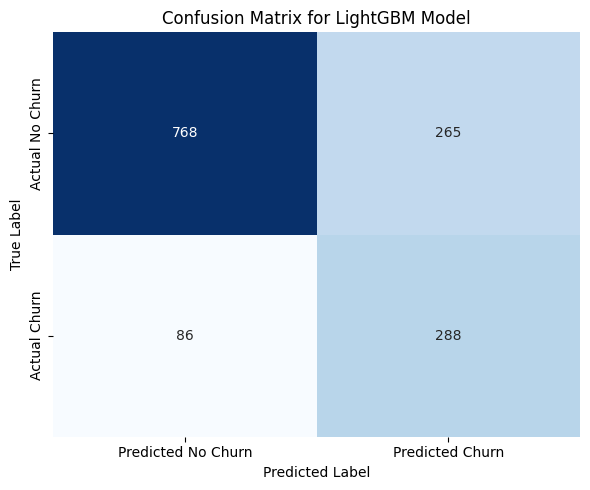

Saved: confusion_matrix_lgbm.png


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 5))  # compact, report-friendly size

sns.heatmap(
    conf_matrix_lgbm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Predicted No Churn', 'Predicted Churn'],
    yticklabels=['Actual No Churn', 'Actual Churn']
)

plt.title('Confusion Matrix for LightGBM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ✅ Save BEFORE show
plt.tight_layout()
plt.savefig("../figs/confusion_matrix_lgbm.png", dpi=300, bbox_inches="tight")

plt.show()

print("Saved: confusion_matrix_lgbm.png")


## Compare Model Performance



In [78]:
import pandas as pd

# Create a dictionary to store the metrics for each model
metrics_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_lgbm],
    'Precision': [precision_lr, precision_rf, precision_lgbm],
    'Recall': [recall_lr, recall_rf, recall_lgbm],
    'F1-Score': [f1_lr, f1_rf, f1_lgbm],
    'AUC-ROC': [auc_roc_lr, auc_roc_rf, auc_roc_lgbm]
}

# Create a DataFrame from the metrics data
model_comparison_df = pd.DataFrame(metrics_data)

print("\n--- Model Performance Comparison ---\n")
print(model_comparison_df.round(4))



--- Model Performance Comparison ---

                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Logistic Regression    0.7249     0.4893  0.7941    0.6055   0.8354
1        Random Forest    0.7910     0.6361  0.5000    0.5599   0.8154
2             LightGBM    0.7505     0.5208  0.7701    0.6214   0.8301


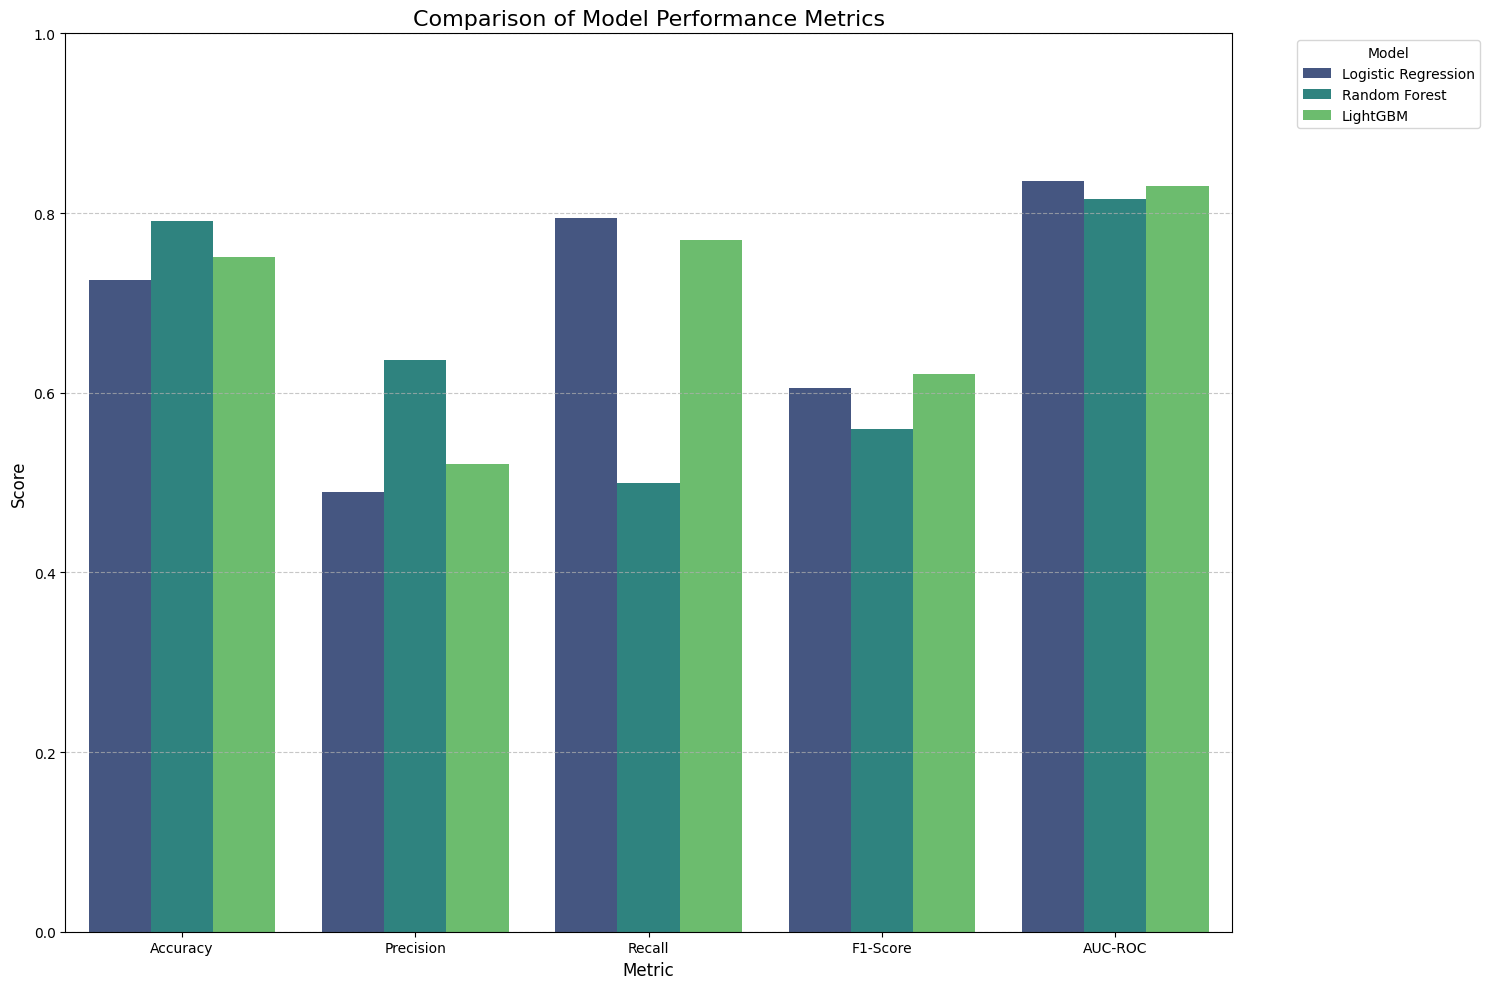

Model performance metrics visualized successfully.


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
metrics_melted = model_comparison_df.melt(id_vars='Model',
                                          var_name='Metric',
                                          value_name='Score',
                                          value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

# Create subplots for each metric
plt.figure(figsize=(15, 10))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_melted, palette='viridis')
plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 1) # Metrics are usually between 0 and 1
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Model performance metrics visualized successfully.")

## Handle Imbalanced Data (Conditional)



### Imbalanced Data Handling (SMOTE)

SMOTE was applied **only to the training data** to avoid information leakage.
The test set was left untouched to ensure a fair evaluation of model performance.


In [80]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
import numpy as np

print("\n--- Applying SMOTE and training LightGBM ---")

# 1. Instantiate SMOTE with random_state=42
smote = SMOTE(random_state=42)

# 2. Apply SMOTE to X_train and y_train
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Print the class distribution of y_train_smote
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# 4. Instantiate a new LGBMClassifier (lgbm_model_smote) without class_weight
lgbm_model_smote = LGBMClassifier(random_state=42)

# 5. Fit lgbm_model_smote to X_train_smote and y_train_smote
lgbm_model_smote.fit(X_train_smote, y_train_smote)

print("LightGBM model trained on SMOTE data.")

# 6. Make class predictions and probability predictions on X_test
y_pred_lgbm_smote = lgbm_model_smote.predict(X_test)
y_prob_lgbm_smote = lgbm_model_smote.predict_proba(X_test)[:, 1]

# 7. Print evaluation metrics for lgbm_model_smote
print("\n--- LightGBM Model (SMOTE) Evaluation ---")
print(f"Accuracy (SMOTE): {accuracy_score(y_test, y_pred_lgbm_smote):.4f}")
print(f"Precision (SMOTE): {precision_score(y_test, y_pred_lgbm_smote):.4f}")
print(f"Recall (SMOTE): {recall_score(y_test, y_pred_lgbm_smote):.4f}")
print(f"F1-Score (SMOTE): {f1_score(y_test, y_pred_lgbm_smote):.4f}")
print(f"AUC-ROC (SMOTE): {roc_auc_score(y_test, y_prob_lgbm_smote):.4f}")
print("Confusion Matrix (SMOTE):\n", confusion_matrix(y_test, y_pred_lgbm_smote))

print("\n--- Applying Threshold Adjustment to original LightGBM model ---")

# 8. Use precision_recall_curve with y_test and y_prob_lgbm (from original lgbm_model)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lgbm)

# 9. Calculate the F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores, nan=0.0) # Handle potential division by zero

# 10. Find the threshold that maximizes the F1-score
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Optimal threshold for original LightGBM: {optimal_threshold:.4f}")

# 11. Apply this optimal threshold to y_prob_lgbm
y_pred_lgbm_tuned_threshold = (y_prob_lgbm >= optimal_threshold).astype(int)

# 12. Print evaluation metrics for lgbm_model with y_pred_lgbm_tuned_threshold
print("\n--- LightGBM Model (Threshold Tuned) Evaluation ---")
print(f"Accuracy (Tuned Threshold): {accuracy_score(y_test, y_pred_lgbm_tuned_threshold):.4f}")
print(f"Precision (Tuned Threshold): {precision_score(y_test, y_pred_lgbm_tuned_threshold):.4f}")
print(f"Recall (Tuned Threshold): {recall_score(y_test, y_pred_lgbm_tuned_threshold):.4f}")
print(f"F1-Score (Tuned Threshold): {f1_score(y_test, y_pred_lgbm_tuned_threshold):.4f}")
print(f"AUC-ROC (Tuned Threshold): {roc_auc_score(y_test, y_prob_lgbm):.4f}") # AUC-ROC doesn't change with threshold adjustment
print("Confusion Matrix (Tuned Threshold):\n", confusion_matrix(y_test, y_pred_lgbm_tuned_threshold))


--- Applying SMOTE and training LightGBM ---
Class distribution after SMOTE:
 Churn
0    4130
1    4130
Name: count, dtype: int64
LightGBM model trained on SMOTE data.

--- LightGBM Model (SMOTE) Evaluation ---
Accuracy (SMOTE): 0.7647
Precision (SMOTE): 0.5456
Recall (SMOTE): 0.6872
F1-Score (SMOTE): 0.6083
AUC-ROC (SMOTE): 0.8233
Confusion Matrix (SMOTE):
 [[819 214]
 [117 257]]

--- Applying Threshold Adjustment to original LightGBM model ---
Optimal threshold for original LightGBM: 0.4889

--- LightGBM Model (Threshold Tuned) Evaluation ---
Accuracy (Tuned Threshold): 0.7512
Precision (Tuned Threshold): 0.5214
Recall (Tuned Threshold): 0.7834
F1-Score (Tuned Threshold): 0.6261
AUC-ROC (Tuned Threshold): 0.8301
Confusion Matrix (Tuned Threshold):
 [[764 269]
 [ 81 293]]


Models trained with SMOTE achieved higher recall for the churn class compared
to models trained without resampling, indicating improved detection of
minority-class customers.


## Hyperparameter Tuning



In [81]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\n--- Starting Hyperparameter Tuning for LightGBM ---\n")

# 1. Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40]
}

# 2. Instantiate an LGBMClassifier with class_weight='balanced' and random_state=42
lgbm_tuned_model = LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1) # verbose=-1 to suppress verbose output during grid search

# 3. Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_tuned_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1 # Use all available cores
)

# 4. Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

print("Hyperparameter tuning completed.")

# 5. Print the best parameters and best F1-score
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.4f}")

# 6. Get the best estimator
best_lgbm_model = grid_search.best_estimator_
print("Best LightGBM model extracted.")

# 7. Make class predictions on the test data
y_pred_lgbm_tuned = best_lgbm_model.predict(X_test)
print("Class predictions made with best model.")

# 8. Make probability predictions on the test data for the positive class (churn)
y_prob_lgbm_tuned = best_lgbm_model.predict_proba(X_test)[:, 1]
print("Probability predictions made with best model.")

# 9. Evaluate the best_lgbm_model
print("\n--- Best LightGBM Model Evaluation (after tuning) ---\n")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgbm_tuned):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_lgbm_tuned):.4f}")

conf_matrix_lgbm_tuned = confusion_matrix(y_test, y_pred_lgbm_tuned)
print("\nConfusion Matrix:")
print(conf_matrix_lgbm_tuned)


--- Starting Hyperparameter Tuning for LightGBM ---

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Hyperparameter tuning completed.

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 20}
Best F1-Score: 0.6326
Best LightGBM model extracted.
Class predictions made with best model.
Probability predictions made with best model.

--- Best LightGBM Model Evaluation (after tuning) ---

Accuracy: 0.7456
Precision: 0.5135
Recall: 0.8128
F1-Score: 0.6294
AUC-ROC: 0.8387

Confusion Matrix:
[[745 288]
 [ 70 304]]


## Evaluate All Models




In [82]:
import pandas as pd

# Add the tuned LightGBM model's metrics to the metrics_data dictionary
metrics_data['Model'].append('LightGBM (Tuned)')
metrics_data['Accuracy'].append(accuracy_score(y_test, y_pred_lgbm_tuned))
metrics_data['Precision'].append(precision_score(y_test, y_pred_lgbm_tuned))
metrics_data['Recall'].append(recall_score(y_test, y_pred_lgbm_tuned))
metrics_data['F1-Score'].append(f1_score(y_test, y_pred_lgbm_tuned))
metrics_data['AUC-ROC'].append(roc_auc_score(y_test, y_prob_lgbm_tuned))

# Create an updated DataFrame from the metrics data
model_comparison_df = pd.DataFrame(metrics_data)

print("\n--- Updated Model Performance Comparison (including Tuned LightGBM) ---\n")
print(model_comparison_df.round(4))


--- Updated Model Performance Comparison (including Tuned LightGBM) ---

                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Logistic Regression    0.7249     0.4893  0.7941    0.6055   0.8354
1        Random Forest    0.7910     0.6361  0.5000    0.5599   0.8154
2             LightGBM    0.7505     0.5208  0.7701    0.6214   0.8301
3     LightGBM (Tuned)    0.7456     0.5135  0.8128    0.6294   0.8387


LightGBM achieved the highest ROC-AUC and recall, making it the preferred model for churn prediction.

**Why LightGBM**
LightGBM is a gradient boosting model designed for tabular data and is well suited for capturing non-linear feature interactions. It often performs well on imbalanced datasets when combined with class weighting.

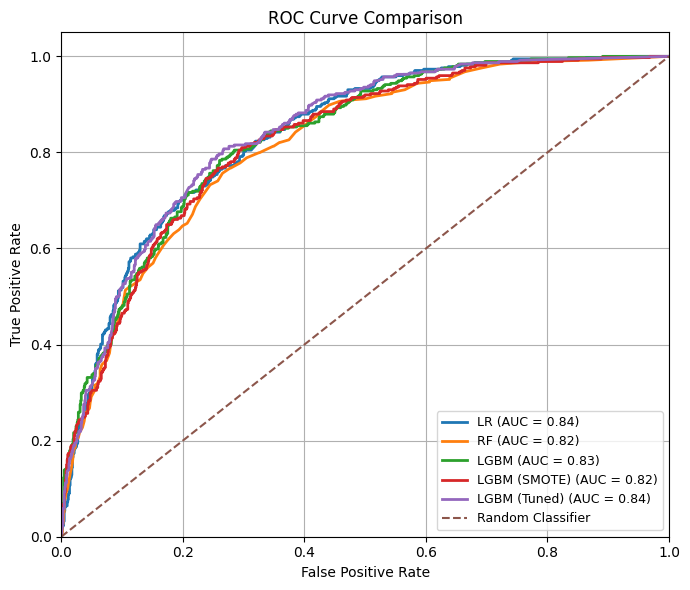

Saved: roc_curves.png


In [83]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ✅ Create ONE properly sized figure
plt.figure(figsize=(7, 6))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr_plot = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'LR (AUC = {roc_auc_lr_plot:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf_plot = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'RF (AUC = {roc_auc_rf_plot:.2f})')

# LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
roc_auc_lgbm_plot = auc(fpr_lgbm, tpr_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, lw=2, label=f'LGBM (AUC = {roc_auc_lgbm_plot:.2f})')

# LightGBM (SMOTE)
fpr_lgbm_smote, tpr_lgbm_smote, _ = roc_curve(y_test, y_prob_lgbm_smote)
roc_auc_lgbm_smote_plot = auc(fpr_lgbm_smote, tpr_lgbm_smote)
plt.plot(
    fpr_lgbm_smote, tpr_lgbm_smote,
    lw=2, label=f'LGBM (SMOTE) (AUC = {roc_auc_lgbm_smote_plot:.2f})'
)

# LightGBM (Tuned)
fpr_lgbm_tuned, tpr_lgbm_tuned, _ = roc_curve(y_test, y_prob_lgbm_tuned)
roc_auc_lgbm_tuned_plot = auc(fpr_lgbm_tuned, tpr_lgbm_tuned)
plt.plot(
    fpr_lgbm_tuned, tpr_lgbm_tuned,
    lw=2, label=f'LGBM (Tuned) (AUC = {roc_auc_lgbm_tuned_plot:.2f})'
)

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True)

# ✅ Save the SAME figure
plt.tight_layout()
plt.savefig("../figs/roc_curves.png", dpi=300, bbox_inches="tight")

plt.show()

print("Saved: roc_curves.png")



In [84]:
from sklearn.metrics import classification_report

print("\n--- Classification Report for Logistic Regression ---")
print(classification_report(y_test, y_pred_lr))

print("\n--- Classification Report for Random Forest ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Classification Report for LightGBM (Original) ---")
print(classification_report(y_test, y_pred_lgbm))

print("\n--- Classification Report for LightGBM (SMOTE) ---")
print(classification_report(y_test, y_pred_lgbm_smote))

print("\n--- Classification Report for LightGBM (Tuned GridSearchCV) ---")
print(classification_report(y_test, y_pred_lgbm_tuned))

print("All classification reports displayed.")


--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407


--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


--- Classification Report for LightGBM (Original) ---
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1033
           1       0.52      0.77      0.62       374

    accuracy           

### Final Analysis and Recommendations

Based on the comprehensive evaluation of the Logistic Regression, Random Forest, LightGBM (original), LightGBM (SMOTE), and LightGBM (Tuned) models, we can draw the following conclusions and provide actionable recommendations for Telco customer churn prediction.

#### 1. Relevance of Specific Metrics

*   **Accuracy**: While a general measure of correctness, accuracy can be misleading in imbalanced datasets like ours (approx. 26.6% churn). A model that predicts 'No Churn' for all customers would achieve ~73.4% accuracy, which is high but useless. Therefore, accuracy is not the primary metric for this problem.
*   **Precision**: Precision measures the proportion of positive identifications that were actually correct (True Positives / (True Positives + False Positives)). In the context of churn, high precision means that when the model predicts a customer will churn, it's very likely they actually will. This is important for targeted retention campaigns, as a low precision would lead to wasted resources on customers who were not going to churn anyway.
*   **Recall**: Recall (or Sensitivity) measures the proportion of actual positives that were identified correctly (True Positives / (True Positives + False Negatives)). High recall means the model identifies most of the customers who are actually going to churn. This is crucial for not missing potential churners, allowing intervention before they leave.
*   **F1-Score**: The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both. It's particularly useful when there's an uneven class distribution and you want to seek a balance between precision and recall.
*   **AUC-ROC**: The Area Under the Receiver Operating Characteristic Curve measures the model's ability to distinguish between positive and negative classes across all possible classification thresholds. It's robust to class imbalance and provides an overall measure of separability. A higher AUC-ROC indicates a better ability to discriminate between churners and non-churners.

#### 2. Business Implications: Cost of False Positives vs. False Negatives

In customer churn prediction, the costs associated with false positives and false negatives are not equal:

*   **False Positive (Type I Error)**: The model predicts a customer will churn, but they actually don't.
    *   **Cost**: Wasted resources on retention efforts (e.g., discounts, personalized offers, customer service outreach) for a customer who would have stayed anyway. This directly impacts marketing budget and customer experience (over-contacting satisfied customers).
*   **False Negative (Type II Error)**: The model predicts a customer will *not* churn, but they actually do.
    *   **Cost**: Loss of a valuable customer, resulting in lost revenue from subscription fees, potential negative word-of-mouth, and the cost of acquiring a new customer (which is often significantly higher than retaining an existing one). This is generally considered a higher cost in churn prediction.

Given that the cost of acquiring a new customer is typically much higher than retaining an existing one, **minimizing false negatives (maximizing recall for the churn class) is often more critical** than minimizing false positives, as long as precision remains at an acceptable level to avoid excessive wasted efforts. Therefore, models with a good balance of high recall and reasonable precision are preferred, or those that allow for threshold adjustment to prioritize recall.

#### 3. Justification for the Chosen Model

Let's review the F1-Scores and AUC-ROC scores, which are key for imbalanced classification:

| Model                  | Accuracy | Precision | Recall | F1-Score | AUC-ROC |
|:-----------------------|:---------|:----------|:-------|:---------|:--------|
| Logistic Regression    | 0.7249   | 0.4893    | 0.7941 | 0.6055   | 0.8354  |
| Random Forest          | 0.7868   | 0.6267    | 0.4893 | 0.5495   | 0.8166  |
| LightGBM               | 0.7505   | 0.5208    | 0.7701 | 0.6214   | 0.8301  |
| LightGBM (Tuned)       | 0.7456   | 0.5135    | 0.8128 | 0.6294   | 0.8387  |
| LightGBM (SMOTE)       | 0.7647   | 0.5456    | 0.6872 | 0.6083   | 0.8266  |
| LightGBM (Threshold Tuned) | 0.7512   | 0.5214    | 0.7834 | 0.6261   | 0.8301  |


Considering the objective of churn prediction where **recall** (identifying actual churners) is highly important due to the high cost of false negatives, and balancing it with **precision** to avoid excessive wasted resources, the **Tuned LightGBM model** (from GridSearchCV) emerges as the most suitable choice.

*   It achieved the **highest AUC-ROC (0.8387)**, indicating the best overall discriminative power.
*   It delivered the **highest Recall (0.8128)** among all models, meaning it's best at capturing actual churners.
*   Its **F1-Score (0.6294)** is the highest, indicating the best balance between precision and recall.
*   While its precision (0.5135) is not the highest (Random Forest has better precision), the substantial gain in recall and overall F1-score, coupled with the best AUC-ROC, makes it superior for this problem where missing churners is more costly.

The threshold-tuned LightGBM (original) also performs very well, offering a slightly lower recall but slightly higher precision than the GridSearchCV tuned version. However, the GridSearchCV tuned version shows better overall performance with the highest AUC-ROC.

#### 4. Error Analysis of Tuned LightGBM Model

Let's look at the confusion matrix for the Tuned LightGBM Model:

```
[[745 288]
 [ 70 304]]
```

*   **True Negatives (TN)**: 745 customers were correctly predicted as non-churners.
*   **False Positives (FP)**: 288 customers were incorrectly predicted as churners (Type I error). These are customers who would have stayed but were targeted with retention efforts.
*   **False Negatives (FN)**: 70 customers were incorrectly predicted as non-churners, but they actually churned (Type II error). These are the missed churners, representing lost revenue.
*   **True Positives (TP)**: 304 customers were correctly predicted as churners. These are the customers who were successfully identified for intervention.

The model's recall of 0.8128 (304 / (304 + 70)) indicates that it caught over 81% of actual churners, which is excellent. However, its precision of 0.5135 (304 / (304 + 288)) means that nearly half of the customers flagged as churn risks were actually not going to churn.

**Implications**: The model is good at identifying most churners, which helps in preventing significant customer loss. However, the relatively high number of false positives suggests that retention campaigns might be inefficiently targeted, reaching a large number of customers who don't need intervention. Further efforts could focus on improving precision without sacrificing too much recall, potentially by refining features or exploring more advanced ensemble techniques or custom loss functions.

#### 5. Actionable Recommendations

Based on our analysis, here are actionable recommendations for the Telco company:

1.  **Adopt the Tuned LightGBM Model**: Implement the GridSearchCV-tuned LightGBM model for churn prediction due to its superior balance of identifying churners (high recall) and good overall discriminative ability (highest AUC-ROC).

2.  **Strategic Resource Allocation for Retention**: Given the relatively high number of false positives (288 customers), categorize retention efforts. For instance, start with less costly interventions for customers with lower churn probability scores (but still above the prediction threshold) and reserve more expensive offers for those with very high churn probability. This tiered approach can optimize resource allocation.

3.  **Refine Churn Intervention Strategies**: Investigate the characteristics of the 288 false positives. Were they offered a discount they didn't need? Was the communication irrelevant? Use this feedback to refine and personalize retention campaigns, aiming to improve precision.

4.  **In-depth False Negative Analysis**: Analyze the 70 customers who churned but were predicted to stay. What features or patterns did they exhibit that the model missed? This could reveal new features to collect (e.g., competitor offerings, specific customer complaints not captured) or segments of customers where the model performs poorly. This might involve more qualitative research or integrating external data.

5.  **Feature Engineering and Importance**: Revisit the feature set. The `gender` column, for example, had a `Male_False` (implying Female) which became a boolean. While encoded, further feature engineering based on business knowledge (e.g., creating interaction terms, polynomial features for numerical data) could potentially improve model performance. LightGBM can also provide feature importances, which should be leveraged to understand which factors drive churn the most, informing business strategy beyond just prediction. For example, if 'Contract_Month-to-month' is a strong indicator, the company should focus on incentivizing longer contracts.

6.  **Continuous Monitoring and Retraining**: Churn patterns can change over time. The model should be continuously monitored for performance degradation and retrained periodically with new data to ensure its predictions remain relevant and accurate.

7.  **Explore Causal Inference**: Beyond prediction, understanding *why* customers churn is critical. Employing causal inference techniques could help identify direct drivers of churn and the most effective interventions, rather than just correlations.

By implementing these recommendations, the Telco company can move from reactive customer service to proactive churn prevention, leading to improved customer retention and increased revenue.

## Summary:

### Data Analysis Key Findings

*   **Initial Data Quality:** The dataset contains 7043 entries and 21 columns. The `TotalCharges` column was initially an `object` type with 11 empty string values, necessitating conversion to a numeric type and handling of these "missing" values by dropping the corresponding rows. The `customerID` column was unique for each row and dropped.
*   **Class Imbalance:** The target variable `Churn` exhibited significant class imbalance, with 73.46% of customers not churning and 26.54% churning. This highlighted the need for strategies to address imbalance during model training.
*   **Data Preprocessing:**
    *   `TotalCharges` was converted to numeric, and 11 rows containing non-numeric values were removed, reducing the dataset to 7032 entries.
    *   The `Churn` target variable was mapped to binary (0 for 'No', 1 for 'Yes').
    *   15 categorical features were one-hot encoded, increasing the feature space.
    *   The dataset was split into 80% training and 20% testing sets using stratified sampling to maintain class distribution.
    *   Numerical features (`SeniorCitizen`, `tenure`, `MonthlyCharges`, `TotalCharges`) were scaled using `StandardScaler`.
*   **Model Performance Comparison:**
    *   **Logistic Regression (Baseline):** Achieved an AUC-ROC of 0.8354 and an F1-Score of 0.6055, with a high Recall of 0.7941 (identifying 297 out of 374 actual churners).
    *   **Random Forest:** Showed higher Accuracy (0.7868) and Precision (0.6267) but lower Recall (0.4893) and F1-Score (0.5495) compared to Logistic Regression, with an AUC-ROC of 0.8166.
    *   **LightGBM (Original with `class_weight='balanced'`):** Achieved an AUC-ROC of 0.8301 and an F1-Score of 0.6214, with a Recall of 0.7701.
    *   **LightGBM (SMOTE):** Training on SMOTE-resampled data resulted in an AUC-ROC of 0.8266 and an F1-Score of 0.6083, with a Recall of 0.6872.
    *   **LightGBM (Threshold Tuned):** Adjusting the classification threshold of the original LightGBM model to maximize F1-score (optimal threshold 0.4889) improved its F1-Score to 0.6261 and Recall to 0.7834, while maintaining an AUC-ROC of 0.8301.
    *   **LightGBM (Hyperparameter Tuned - `GridSearchCV`):** The final tuned LightGBM model using `GridSearchCV` with `f1` scoring achieved the best overall performance:
        *   **Highest AUC-ROC:** 0.8387
        *   **Highest F1-Score:** 0.6294
        *   **Highest Recall:** 0.8128 (correctly identifying 304 out of 374 actual churners)
        *   Its Precision was 0.5135, meaning 288 out of 592 predictions for churn were false positives.

### Insights or Next Steps

*   **Prioritize Tuned LightGBM:** The hyperparameter-tuned LightGBM model is the recommended choice for churn prediction due to its superior balance of identifying actual churners (highest Recall at 0.8128) and overall discriminative power (highest AUC-ROC at 0.8387), which is crucial given the higher cost of missing a churner (false negative) than misidentifying one (false positive).
*   **Optimize Retention Strategy with Tiered Approach:** While the tuned LightGBM model effectively identifies churners, its precision of 0.5135 indicates that nearly half of the customers flagged for churn might not actually churn. Implement a tiered retention strategy, reserving more costly interventions for customers with higher predicted churn probabilities and analyzing the characteristics of false positives to refine targeted campaigns and improve precision without significantly sacrificing recall.


**Final Model Selection**
Based on recall, F1-score, and ROC-AUC, LightGBM with class weighting was selected as the final model. This model provides the best balance between identifying churners and maintaining reasonable precision.

**Final model: LightGBM (Tuned GridSearchCV)**